# StockPredictor with LSTM model to predict Tesla stocks

## Import the libraries and packages

In [1]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
# Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Analyzing and visualizing the data

         Date Close/Last
0  09/13/2024    $230.29
1  09/12/2024    $229.81
2  09/11/2024    $228.13
3  09/10/2024    $226.17
4  09/09/2024    $216.27


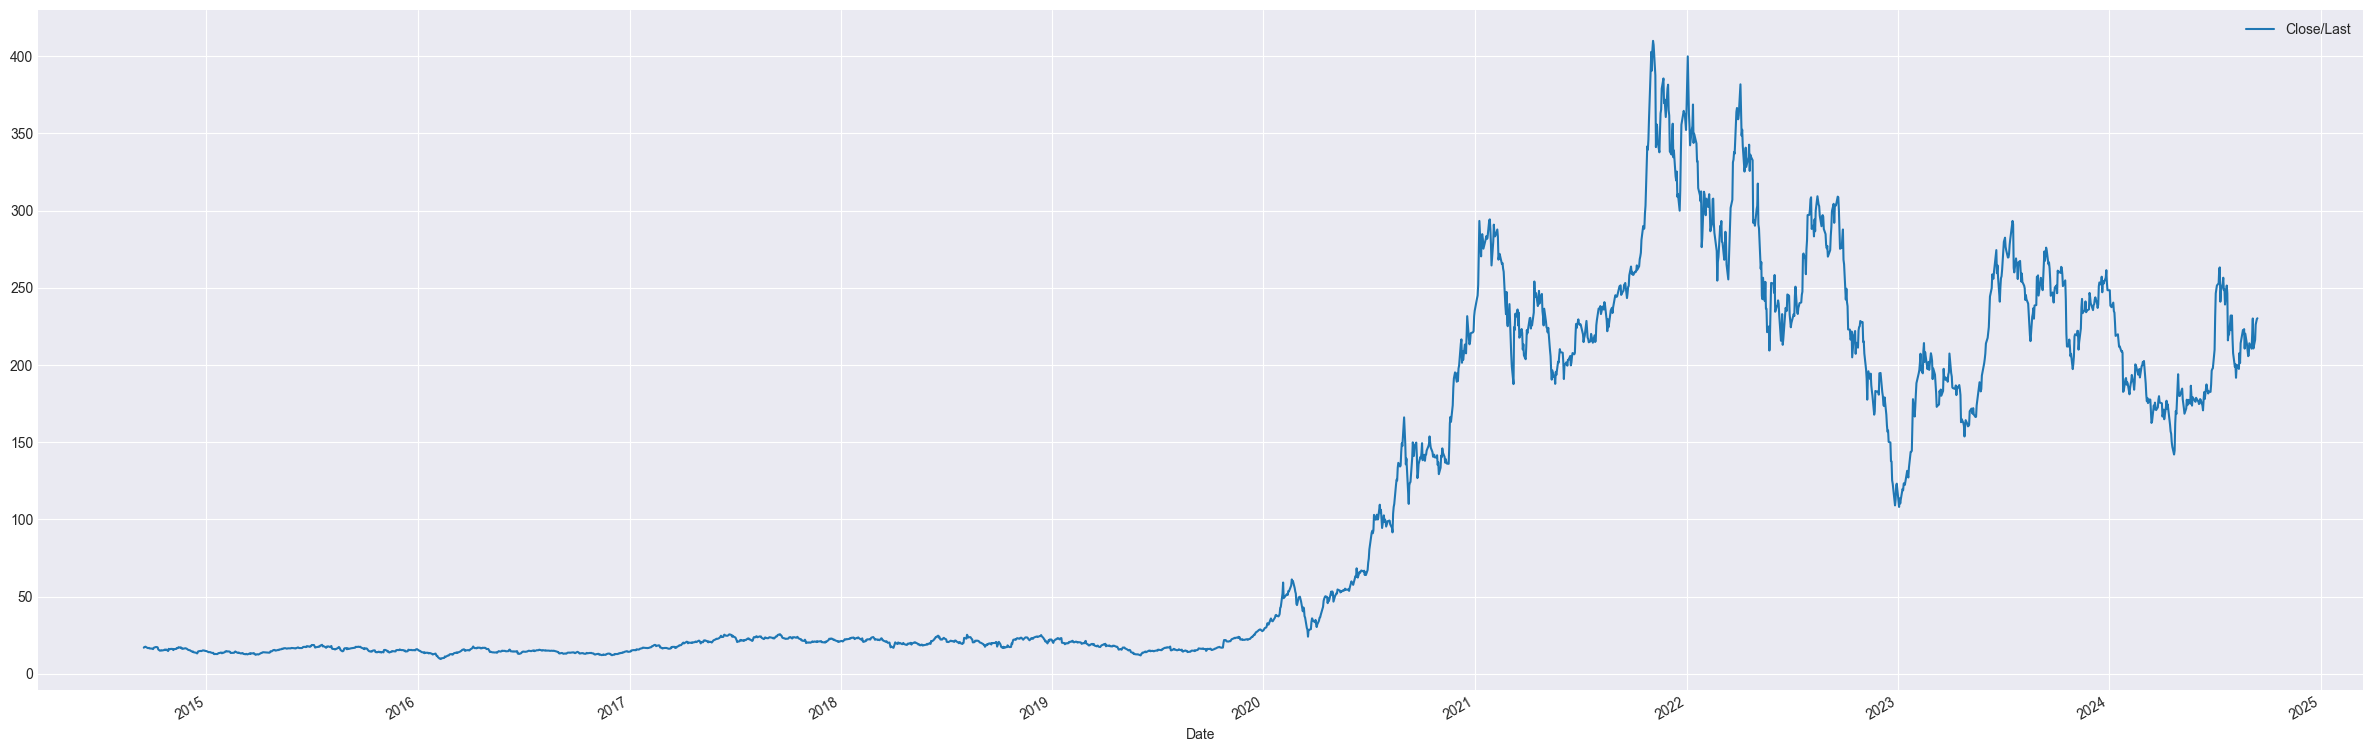

In [3]:
# Sets the columns of what to display
columns = ["Date", "Close/Last"]

# Read the csv file with the 2 columns and print out the first few lines
df_tsla = pd.read_csv("tesla_stocks.csv", usecols=columns)
print(df_tsla.head())

# Removes the "$" spaces and commas so it returns as a float
df_tsla['Close/Last'] = df_tsla['Close/Last'].replace({'\$': '', ',': ''}, regex=True).astype(np.float64)

# Convert 'Date' to datetime format
df_tsla['Date'] = pd.to_datetime(df_tsla['Date'])

# Set 'Date' as the index
df_tsla.set_index('Date', inplace=True)

# Plot the data
df_tsla.plot(figsize=(30, 10), subplots=True, xlabel="Date");

### Training and Testing Sets

In [4]:
df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2024-09-13 to 2014-09-15
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  2517 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_tsla['Close/Last'] = scaler.fit_transform(df_tsla['Close/Last'].values.reshape(-1,1))
# df_tsla['Volume'] = scaler.fit_transform(df_tsla['Volume'].values.reshape(-1,1))

df_tsla.head()

,Close/Last
Date,
2024-09-13,0.102480
2024-09-12,0.100082
2024-09-11,0.091690
2024-09-10,0.081900
2024-09-09,0.032448


In [6]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.to_numpy() # convert dataframe to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    train_set_size = int(np.round(0.8 * data.shape[0]))
    
    X_train = data[:train_set_size,:-1,:]
    Y_train = data[:train_set_size,-1,:]
    
    X_test = data[train_set_size:,:-1]
    Y_test = data[train_set_size:,-1,:]
    
    return [X_train, Y_train, X_test, Y_test]

In [21]:
look_back = 60 # choose sequence length
X_train, Y_train, X_test, Y_test = load_data(df_tsla, look_back)
print('X_train.shape = ',X_train.shape)
print('Y_train.shape = ',Y_train.shape)
print('X_test.shape = ',X_test.shape)
print('Y_test.shape = ',Y_test.shape)

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
Y_train = torch.from_numpy(Y_train).type(torch.Tensor)
Y_test = torch.from_numpy(Y_test).type(torch.Tensor)

X_train.shape =  (1966, 59, 1)
Y_train.shape =  (1966, 1)
X_test.shape =  (491, 59, 1)
Y_test.shape =  (491, 1)


In [8]:
X_train.shape, Y_train.shape

(torch.Size([1966, 59, 1]), torch.Size([1966, 1]))

### Building a LSTM model

In [9]:
# Building the model structure
input_dim = 1
hidden_dim = 32 # hidden units per hidden LSTM layer
num_layers = 2
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Loss function and optimizer

In [10]:
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.02)

## Train Model

In [11]:
# Train model
#####################
epochs = 500
hist = np.zeros(epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for epoch in range(epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, Y_train)
    if epoch % 10 == 0 and epoch !=0:
        print(f"Epoch: {epoch} MSE: {loss.item()}")
    hist[epoch] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch: 10 MSE: 0.03762444108724594
Epoch: 20 MSE: 0.010684065520763397
Epoch: 30 MSE: 0.004355230834335089
Epoch: 40 MSE: 0.002508991863578558
Epoch: 50 MSE: 0.001809786888770759
Epoch: 60 MSE: 0.0015487679047510028
Epoch: 70 MSE: 0.0014771925052627921
Epoch: 80 MSE: 0.001397965126670897
Epoch: 90 MSE: 0.0013439885806292295
Epoch: 100 MSE: 0.0012970728566870093
Epoch: 110 MSE: 0.0012524562189355493
Epoch: 120 MSE: 0.001210890244692564
Epoch: 130 MSE: 0.0011702743358910084
Epoch: 140 MSE: 0.0011314877774566412
Epoch: 150 MSE: 0.0010953240562230349
Epoch: 160 MSE: 0.0010630916804075241
Epoch: 170 MSE: 0.0010363199980929494
Epoch: 180 MSE: 0.0010161116952076554
Epoch: 190 MSE: 0.001002305536530912
Epoch: 200 MSE: 0.0009934386471286416
Epoch: 210 MSE: 0.0009942920878529549
Epoch: 220 MSE: 0.0011455343337729573
Epoch: 230 MSE: 0.0010136822238564491
Epoch: 240 MSE: 0.0009882196318358183
Epoch: 250 MSE: 0.0009834414813667536
Epoch: 260 MSE: 0.0009804528672248125
Epoch: 270 MSE: 0.000977465766

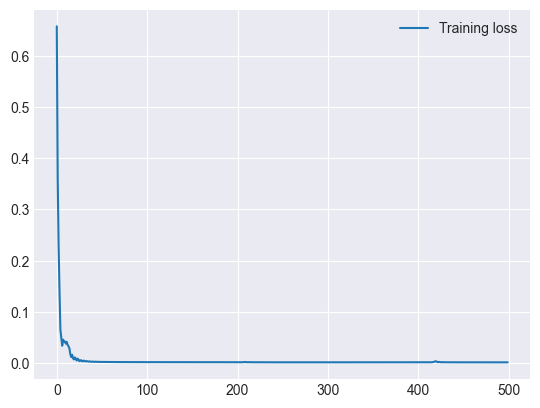

In [16]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [17]:
np.shape(y_train_pred)

(1966, 1)

### Make Predictions

In [22]:
# make predictions
y_test_pred = model(X_test)
y_train_pred = model(X_train)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
Y_train = scaler.inverse_transform(Y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
Y_test = scaler.inverse_transform(Y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.11 RMSE
Test Score: 0.51 RMSE


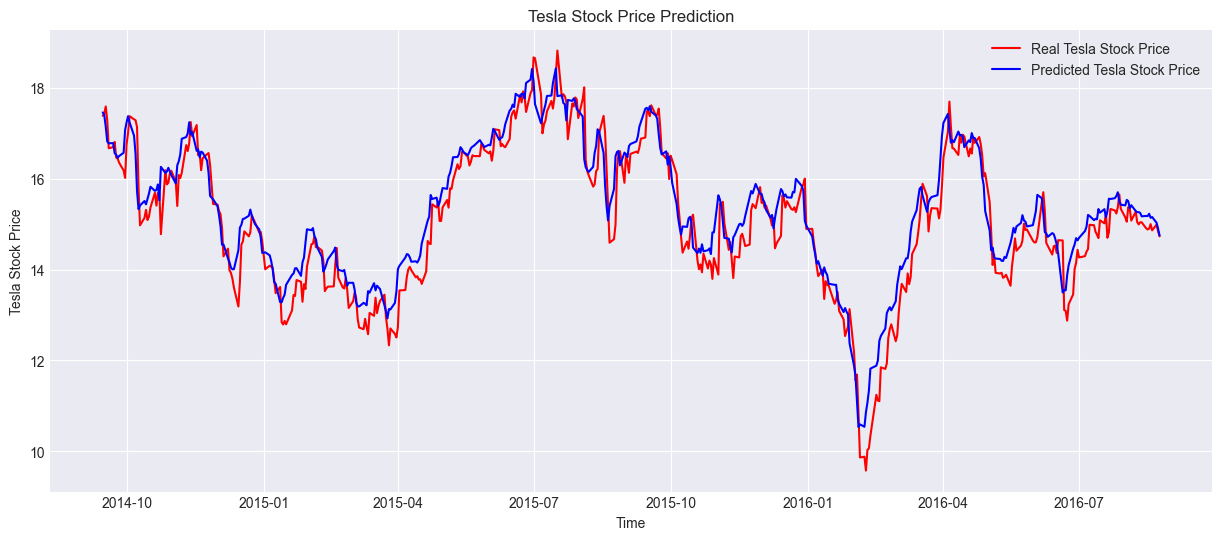

In [23]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_tsla[len(df_tsla)-len(Y_test):].index, Y_test, color = 'red', label = 'Real Tesla Stock Price')
axes.plot(df_tsla[len(df_tsla)-len(Y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Tesla Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.savefig(""")
plt.show()